In [1]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Linux-5.15.154+-x86_64-with-glibc2.31


In [2]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
print("Tensorflow version " + tf.__version__)

2024-08-20 20:12:08.526065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 20:12:08.526129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 20:12:08.527560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Tue Aug 20 20:12:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
MyDrive = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\kaggle'
PROJECT_DIR = r'C:\Users\malak\OneDrive\Documents\Image Processing Project\SCVD\SCVD_converted'

In [4]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 3 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [5]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Train'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/Normal'))))

X_original = []
y_original = []

# print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["Normal", "Violence"]
#700 <- 350 + 350

for category in CLASSES:
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path))):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
99 Violence videos 
200 NonViolence videos


100%|██████████| 99/99 [03:00<00:00,  1.83s/it]

CPU times: user 13min 47s, sys: 3min 12s, total: 16min 59s
Wall time: 5min 31s


In [19]:
VideoDataDir_Test = PROJECT_DIR + '/Test'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir_Test + '/Violence')), 
              len(os.listdir(VideoDataDir_Test + '/Normal'))))
X_test_1 = []
y_test_1 = []
for category in CLASSES:
    path = os.path.join(VideoDataDir_Test, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path))):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_test_1.append(frame)
            y_test_1.append(class_num)            

we have 
12 Violence videos 
46 NonViolence videos


100%|██████████| 12/12 [00:21<00:00,  1.83s/it]


In [7]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

20498

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [9]:
!pip install imutils

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=939c3a072a62efdcb729598b1e0715343a87e0833fc31a68a779c277a2f6fd8a
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [10]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [11]:
epochs = 50

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

/tmp/ipykernel_197/3041328146.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(pooling='avg',


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 5

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [13]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

# PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [14]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/50
  10/3587 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.4799 - loss: 0.8751   

I0000 00:00:1724185167.655156    1692 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3578/3587 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5898 - loss: 0.7426
Epoch 1: val_loss improved from inf to 0.66788, saving model to ModelWeights.weights.h5
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - accuracy: 0.5898 - loss: 0.7425 - val_accuracy: 0.6328 - val_loss: 0.6679 - learning_rate: 1.0000e-05
Epoch 2/50
3581/3587 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6613 - loss: 0.6353
Epoch 2: val_loss improved from 0.66788 to 0.56741, saving model to ModelWeights.weights.h5
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.6614 - loss: 0.6352 - val_accuracy: 0.7125 - val_loss: 0.5674 - learning_rate: 1.8000e-05
Epoch 3/50
3584/3587 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7326 - loss: 0.5406
Epoch 3: val_loss improved from 0.56741 to 0.48869, saving model to ModelWeights.weights.h5
3587/3587 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.7326 - loss: 0.5406 - val_accuracy: 0.7785 - val_loss: 0.4887 - learning_rate: 2.6000e-05
Epoch 4/50
3586/3587 ━━━━━━━━━

In [15]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)                

------------------------------------------------------------------------------------------
Best Epochs:  45
Accuracy on train: 0.926958441734314 	Loss on train: 0.20817242562770844
Accuracy on test: 0.9164227843284607 	Loss on test: 0.22126874327659607


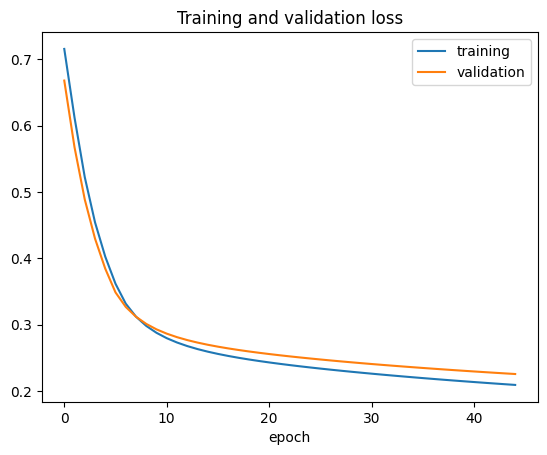

<Figure size 640x480 with 0 Axes>

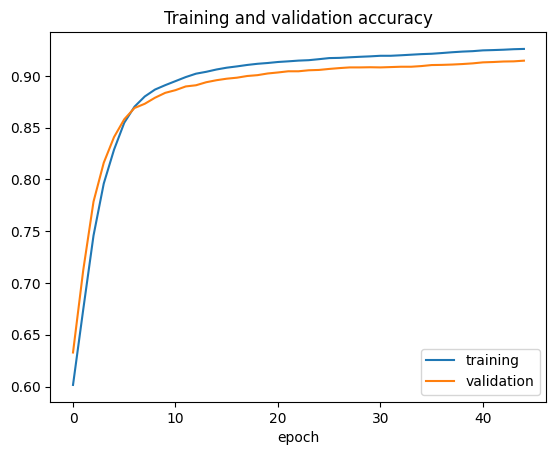

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [16]:
model_summary(model, history)

In [17]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


> Correct Predictions: 5636
> Wrong Predictions: 514


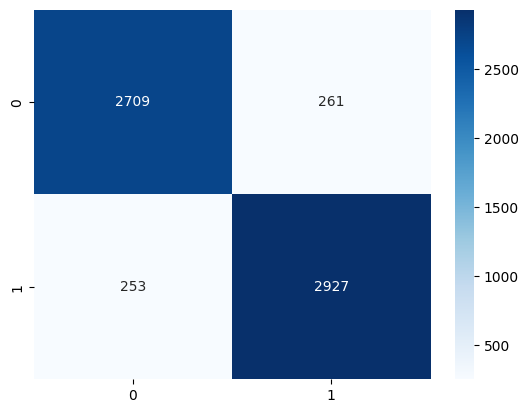

              precision    recall  f1-score   support

 NonViolence       0.91      0.91      0.91      2970
    Violence       0.92      0.92      0.92      3180

    accuracy                           0.92      6150
   macro avg       0.92      0.92      0.92      6150
weighted avg       0.92      0.92      0.92      6150



In [18]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int32((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int32((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

In [20]:
import numpy as np
X_test_1 = np.array(X_test_1).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_test_1 = np.array(y_test_1)
len(X_test_1)

3203

In [21]:
X_test_1_nn = X_test_1.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [24]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_1_nn)
preds = predictions > 0.5

Evaluating network...
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


> Correct Predictions: 3105
> Wrong Predictions: 98


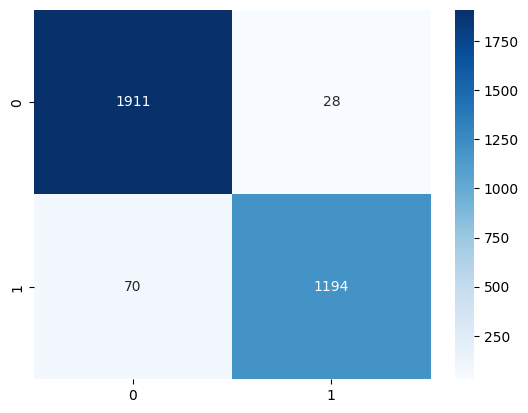

              precision    recall  f1-score   support

 NonViolence       0.96      0.99      0.97      1939
    Violence       0.98      0.94      0.96      1264

    accuracy                           0.97      3203
   macro avg       0.97      0.97      0.97      3203
weighted avg       0.97      0.97      0.97      3203



In [25]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test_1, preds)

n_correct = np.int32((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int32((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test_1, preds, 
                           target_names=["NonViolence", "Violence"]))